### Import packages 

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import os
import requests
from io import StringIO
import pymc as pm
import arviz as az
from tqdm import tqdm
import hssm
import random
from hssm.distribution_utils import make_distribution
from hssm.likelihoods import DDM
from scipy.stats import pearsonr
import pytensor.tensor as pt
from pytensor.scan import scan
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import arviz as az

### Set parameters

In [37]:
#wald_model_prior = "log_normal_prior_non_centered"
wald_model_prior = "log_normal_prior_centered"

n_group_param_sets = 30 

n_params_wm = 12 # Number of parameters of the WM (for Bonferroni correction)

### Import synthetic and recovered parameters

In [38]:
df_group_synthetic_params = pd.read_csv(f"synthetic_data/wald_model_synthetic_group_parameters_{wald_model_prior}.csv")
df_group_recovered_params = pd.read_csv(f"recovered_parameters/group_recovered_params_{wald_model_prior}.csv")
df_indi_synthetic_params = pd.read_csv(f"synthetic_data/wald_model_synthetic_indi_parameters_{wald_model_prior}.csv")
df_indi_wm_recovered_params = pd.read_csv(f"recovered_parameters/individual_recovered_params_{wald_model_prior}.csv")
df_indi_ddm_recovered_params = pd.read_csv(f"recovered_parameters/ddm_recovered_parameters.csv")

### Helper functions

In [39]:
def plot_group_parameters(param):
    plt.figure(figsize=(4, 4))

    xs, ys = [], []
    
    for g in range(n_group_param_sets):
        df_g_true = df_group_synthetic_params[df_group_synthetic_params['group_parameter_set_ID'] == g]
        df_g_rec  = df_group_recovered_params[df_group_recovered_params['group_parameter_set_ID'] == g]
    
        x = df_g_true[f'group_log_{param}_mu'].to_numpy()
        y = df_g_rec[f'recovered_group_log_{param}_mu_mean'].to_numpy()
    
        # keep for global limits
        xs.append(x)
        ys.append(y)
    
        plt.scatter(x, y, s=20)

    # compute global min/max across all points
    x_all = np.concatenate(xs)
    y_all = np.concatenate(ys)
    vmin = np.nanmin([x_all.min(), y_all.min()])
    vmax = np.nanmax([x_all.max(), y_all.max()])

    
    # same range on both axes
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    # light grey y=x line
    plt.plot([vmin, vmax], [vmin, vmax], linewidth=1, color='lightgrey', zorder=0)
    
    # labels & title with LaTeX-style math
    plt.xlabel(r"True", fontsize=16)
    plt.ylabel(r"Recovered", fontsize=16)
    if param == "beta0":
        plt.title(r"Group-level $\beta_{0}$")
    elif param == "beta1":
        plt.title(r"Group-level $\beta_{1}$")
    elif param == "beta2":
        plt.title(r"Group-level $\beta_{2}$")
    elif param == "drift":
        plt.title(r"Group-level drift")
    
    # square plot so the diagonal is at 45°
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()

    r, p = pearsonr(x_all, y_all)
    print(f"Pearson correlation: r = {r:.3f}, p = {p:.3e}")

    

In [40]:
def fmt_no_leading_zero(x, digits=3):
    s = f"{x:.{digits}f}"
    if s.startswith("-0."):
        return "-." + s[3:]   # -0.45 -> -.45
    if s.startswith("0."):
        return "." + s[2:]    # 0.45  -> .45
    return s  

In [41]:
def plot_indi_parameters(param):
    plt.figure(figsize=(3, 3))

    xs, ys = [], []
    
    for g in range(n_group_param_sets):
        df_indi_true = df_indi_synthetic_params[df_indi_synthetic_params['group_parameter_set_ID']==g]
        df_indi_rec  = df_indi_wm_recovered_params[df_indi_wm_recovered_params['group_parameter_set_ID']==g]
    
        x = df_indi_true[f'synthetic_indi_{param}'].to_numpy()
        y = df_indi_rec[f'recovered_indi_{param}_mean'].to_numpy()
    
        # keep for global limits
        xs.append(x)
        ys.append(y)
    
    
        plt.scatter(x, y, s=20)

    # compute global min/max across all points
    x_all = np.concatenate(xs)
    y_all = np.concatenate(ys)
    vmin = np.nanmin([x_all.min(), y_all.min()])
    vmax = np.nanmax([x_all.max(), y_all.max()])
    
    # same range on both axes
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    #plt.xlim(0, 3)
    #plt.ylim(0, 3)
    
    # light grey y=x line
    plt.plot([vmin, vmax], [vmin, vmax], linewidth=1, color='lightgrey', zorder=0)
    
    # labels & title with LaTeX-style math
    plt.xlabel(r"True", fontsize=16)
    plt.ylabel(r"Recovered", fontsize=16)
    if param == "beta0":
        plt.title(r"Individual-level $\beta_{0}$")
    elif param == "beta1":
        plt.title(r"Individual-level $\beta_{1}$")
    elif param == "beta2":
        plt.title(r"Individual-level $\beta_{2}$")
    elif param == "drift":
        plt.title(r"Individual-level drift")
    
    # square plot so the diagonal is at 45°
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()

In [42]:
def holm_correct_lower_triangle(P: np.ndarray) -> np.ndarray:
    """
    Holm-correct p-values in the strict lower triangle of P.
    Returns a same-shape matrix with corrected p's in the same cells.
    """
    n = P.shape[0]
    P_holm = P.copy()

    li = np.tril_indices(n, k=-1)     # strict lower triangle indices
    pvals = P[li]
    ok = np.isfinite(pvals)           # exclude NaNs

    if ok.any():
        # multipletests returns (reject, pvals_corr, alphacSidak, alphacBonf)
        _, p_corr, _, _ = multipletests(pvals[ok], method="holm")
        p_out = np.full_like(pvals, np.nan, dtype=float)
        p_out[ok] = p_corr
        P_holm[li] = p_out

    return P_holm


# Wald model parameter recovery analysis

## Check correlation between synthetic and recovered group-level parameters

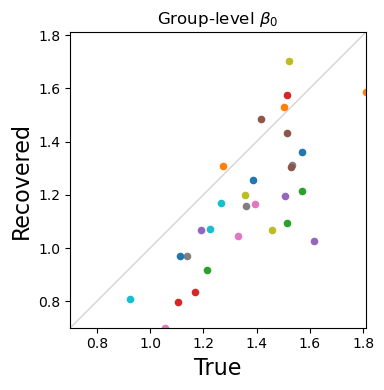

Pearson correlation: r = 0.758, p = 1.226e-06


In [8]:
plot_group_parameters("beta0")

/tmp/ipykernel_2542/2356437563.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


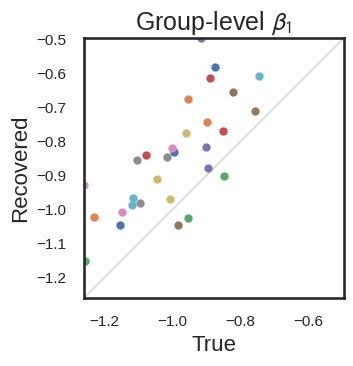

Pearson correlation: r = 0.723, p = 6.482e-06


In [206]:
plot_group_parameters("beta1")


/tmp/ipykernel_2542/2356437563.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


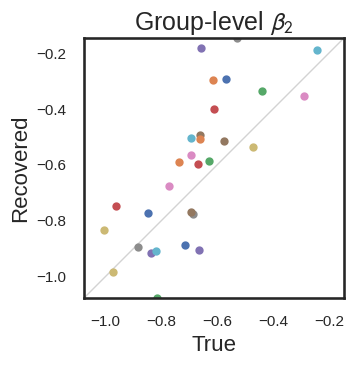

Pearson correlation: r = 0.745, p = 2.311e-06


In [207]:
plot_group_parameters("beta2")

/tmp/ipykernel_2542/2356437563.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


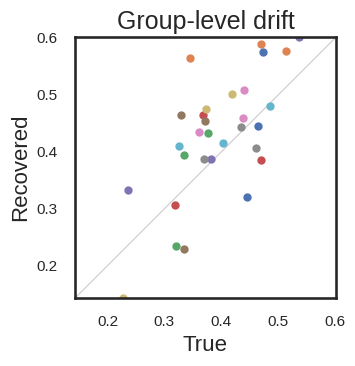

Pearson correlation: r = 0.675, p = 4.280e-05


In [208]:
plot_group_parameters("drift")

## Check correlations between synthetic and recovered individual-level parameters

/tmp/ipykernel_2542/3752979869.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


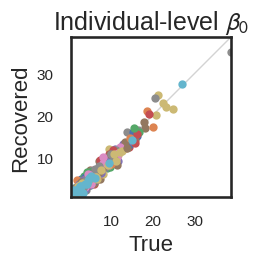

In [209]:
plot_indi_parameters("beta0")

/tmp/ipykernel_2542/3752979869.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


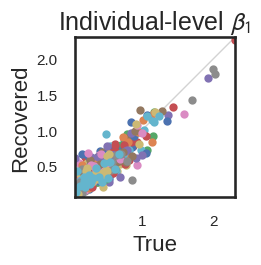

In [210]:
plot_indi_parameters("beta1")

/tmp/ipykernel_2542/3752979869.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


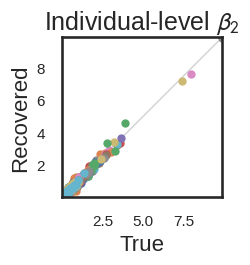

In [211]:
plot_indi_parameters("beta2")

/tmp/ipykernel_2542/3752979869.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


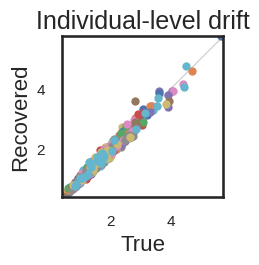

In [212]:
plot_indi_parameters("drift")

## Check correlations between recovered parameters

#### Correlations between group-level recovered parameters

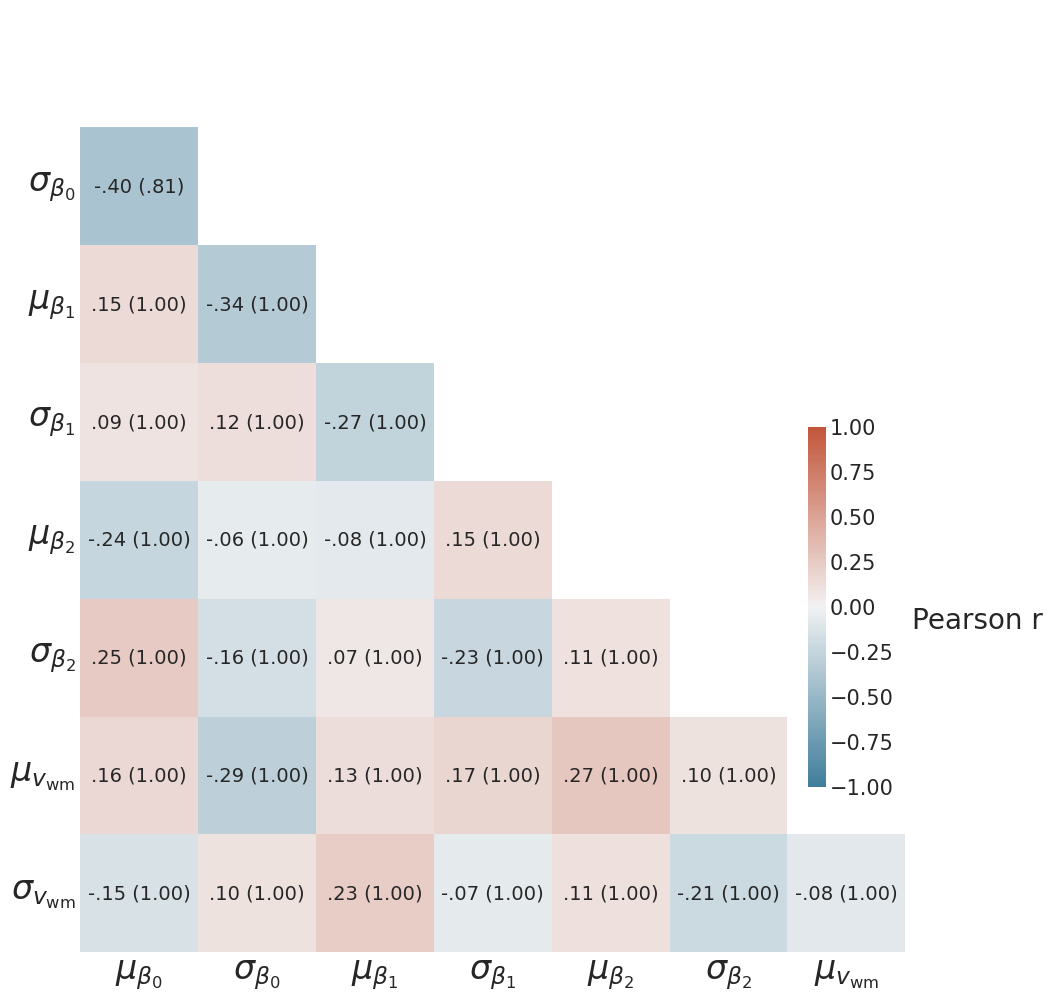

In [9]:
# corr_lower_triangle.py
# Make a lower-triangle Pearson correlation heatmap with r (p) annotations.

# -------------------
# CONFIG: edit these
# -------------------
cols = [
    'recovered_group_log_beta0_mu_mean',
    "recovered_group_log_beta0_sigma_mean",
    'recovered_group_log_beta1_mu_mean',
    "recovered_group_log_beta1_sigma_mean",
    'recovered_group_log_beta2_mu_mean',
    "recovered_group_log_beta2_sigma_mean",
    'recovered_group_log_drift_mu_mean',
    "recovered_group_log_drift_sigma_mean",
]

var_names = [
    r"$\mu_{\beta_{0}}$",
    r"$\sigma_{\beta_{0}}$",
    r"$\mu_{\beta_{1}}$",
    r"$\sigma_{\beta_{1}}$",
    r"$\mu_{\beta_{2}}$",
    r"$\sigma_{\beta_{2}}$",
    r"$\mu_{v_{\text{wm}}}$",
    r"$\sigma_{v_{\text{wm}}}$",
]

# -------------
# DATA SOURCE
# -------------
# Provide your DataFrame here as df_group_recovered_params
# For example:
# df_group_recovered_params = pd.read_csv("your_data.csv")

# ---------------------------------
# Helpers for formatting r and p
# ---------------------------------
def fmt_r(x: float) -> str:
    """Format r to two decimals, no leading zero (e.g., -.23, .07, .00)."""
    if np.isnan(x):
        return ""
    xr = np.round(x, 2)
    if np.isclose(xr, 0.0):
        return ".00"
    s = f"{xr:.2f}"
    if s.startswith("-0."):
        return "-." + s[3:]
    if s.startswith("0."):
        return "." + s[2:]
    return s

def fmt_p(p: float) -> str:
    """Format p like .05 (no leading zero), or <.001 for very small values."""
    if np.isnan(p):
        return ""
    if p < 0.001:
        return "<.001"
    return f"{p:.2f}".lstrip("0")

def build_corr_with_p(df: pd.DataFrame):
    """Compute pairwise Pearson r and p (pairwise complete cases)."""
    names = df.columns.tolist()
    n = len(names)
    R = np.full((n, n), np.nan, dtype=float)
    P = np.full((n, n), np.nan, dtype=float)

    for i in range(n):
        xi = df.iloc[:, i]
        for j in range(i):  # strict lower triangle only (j < i)
            yj = df.iloc[:, j]
            m = xi.notna() & yj.notna()
            if m.sum() >= 2:
                try:
                    r, p = pearsonr(xi[m], yj[m])
                except ValueError:
                    # e.g., constant input; leave as NaN
                    r, p = np.nan, np.nan
                R[i, j] = r
                P[i, j] = p
    return names, R, P

def make_plot(names, R, P, annot_fs=10, label_fs=12, figsize_scale=1.0, linewidths=0):
    """Render seaborn heatmap for the lower triangle with r (p) annotations."""
    n = len(names)
    R_df = pd.DataFrame(R, index=names, columns=names)

    # Mask upper triangle + diagonal
    mask = np.triu(np.ones_like(R_df, dtype=bool), k=0)

    # Build annotation strings
    annot = R_df.copy().astype(object)
    for i in range(n):
        for j in range(n):
            if np.isnan(R[i, j]):
                annot.iat[i, j] = ""
            else:
                annot.iat[i, j] = f"{fmt_r(R[i, j])} ({fmt_p(P[i, j])})"

    sns.set_theme(style="white")
    figsize = (figsize_scale * n, figsize_scale * n)
    f, ax = plt.subplots(figsize=figsize)

    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(
        R_df,
        mask=mask,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        linewidths=linewidths,     # 0 = no visible gridlines
        cbar_kws={"shrink": .7, "label": "Pearson r", "pad": 0.02},
        annot=annot,
        fmt="",
        annot_kws={"fontsize": annot_fs},
    )

    cbar = ax.collections[0].colorbar

    cbar.set_label("Pearson r", rotation=0, labelpad=60, fontsize=20)
    #cbar.ax.yaxis.set_label_position('left')

    # Make the colorbar thinner and closer to the plot
    cbar.ax.set_position([
        ax.get_position().x1-0.1 ,   # move right of the heatmap
        ax.get_position().y0-0.1,          # align bottom
        0.015,                         # width (smaller = thinner)
        ax.get_position().height       # same height as plot
    ])

    
    # Remove tick *lines* but keep tick labels
    cbar.ax.tick_params(size=0, length=0)   # hide tick marks
    # (optional) adjust font size or padding if you want
    cbar.ax.tick_params(labelsize=15, pad=3)

    # Hide the *top* y-axis label and the *last* x-axis label
    xt = [t.get_text() for t in ax.get_xticklabels()]
    yt = [t.get_text() for t in ax.get_yticklabels()]
    
    if xt:  xt[-1] = ""   # last x label
    if yt:  yt[0]  = ""   # top y label
    
    ax.set_xticklabels(xt)
    #ax.set_yticklabels(yt, rotation=90, ha="right")

    ax.set_yticklabels(yt, rotation=0, ha="right", va="center")
    
    # (optional) also remove the little tick marks at those spots
    ax.tick_params(axis="x", which="both", length=0)
    ax.tick_params(axis="y", which="both", length=0)

    ax.tick_params(axis="x", labelsize=label_fs)
    ax.tick_params(axis="y", labelsize=label_fs)
    #f.tight_layout(pad=0.3)
    f.set_constrained_layout(True)
    return f, ax

if __name__ == "__main__":
    # --- Subset, numeric only, and pretty labels ---
    # Ensure df_group_recovered_params exists before running this script.
    try:
        df_source = df_group_recovered_params  # noqa: F821 (provided by caller)
    except NameError:
        raise RuntimeError("Please define df_group_recovered_params before running this script.")

    existing = [c for c in cols if c in df_source.columns]
    label_map = {c: v for c, v in zip(cols, var_names) if c in existing}
    df_plot = (
        df_source
        .loc[:, existing]
        .select_dtypes(include="number")
        .rename(columns=label_map)
    )

    names, R, P = build_corr_with_p(df_plot)
   
    P_holm = holm_correct_lower_triangle(P)

    fig, ax = make_plot(
        names,
        R,
        P_holm,#P
        annot_fs=14,
        label_fs=24,
        figsize_scale=1.5,
        linewidths=0,
    )


    # Optional: save the figure
    #fig.savefig("../figures/wald_group_recovered_corr.svg", bbox_inches="tight")
    plt.show()



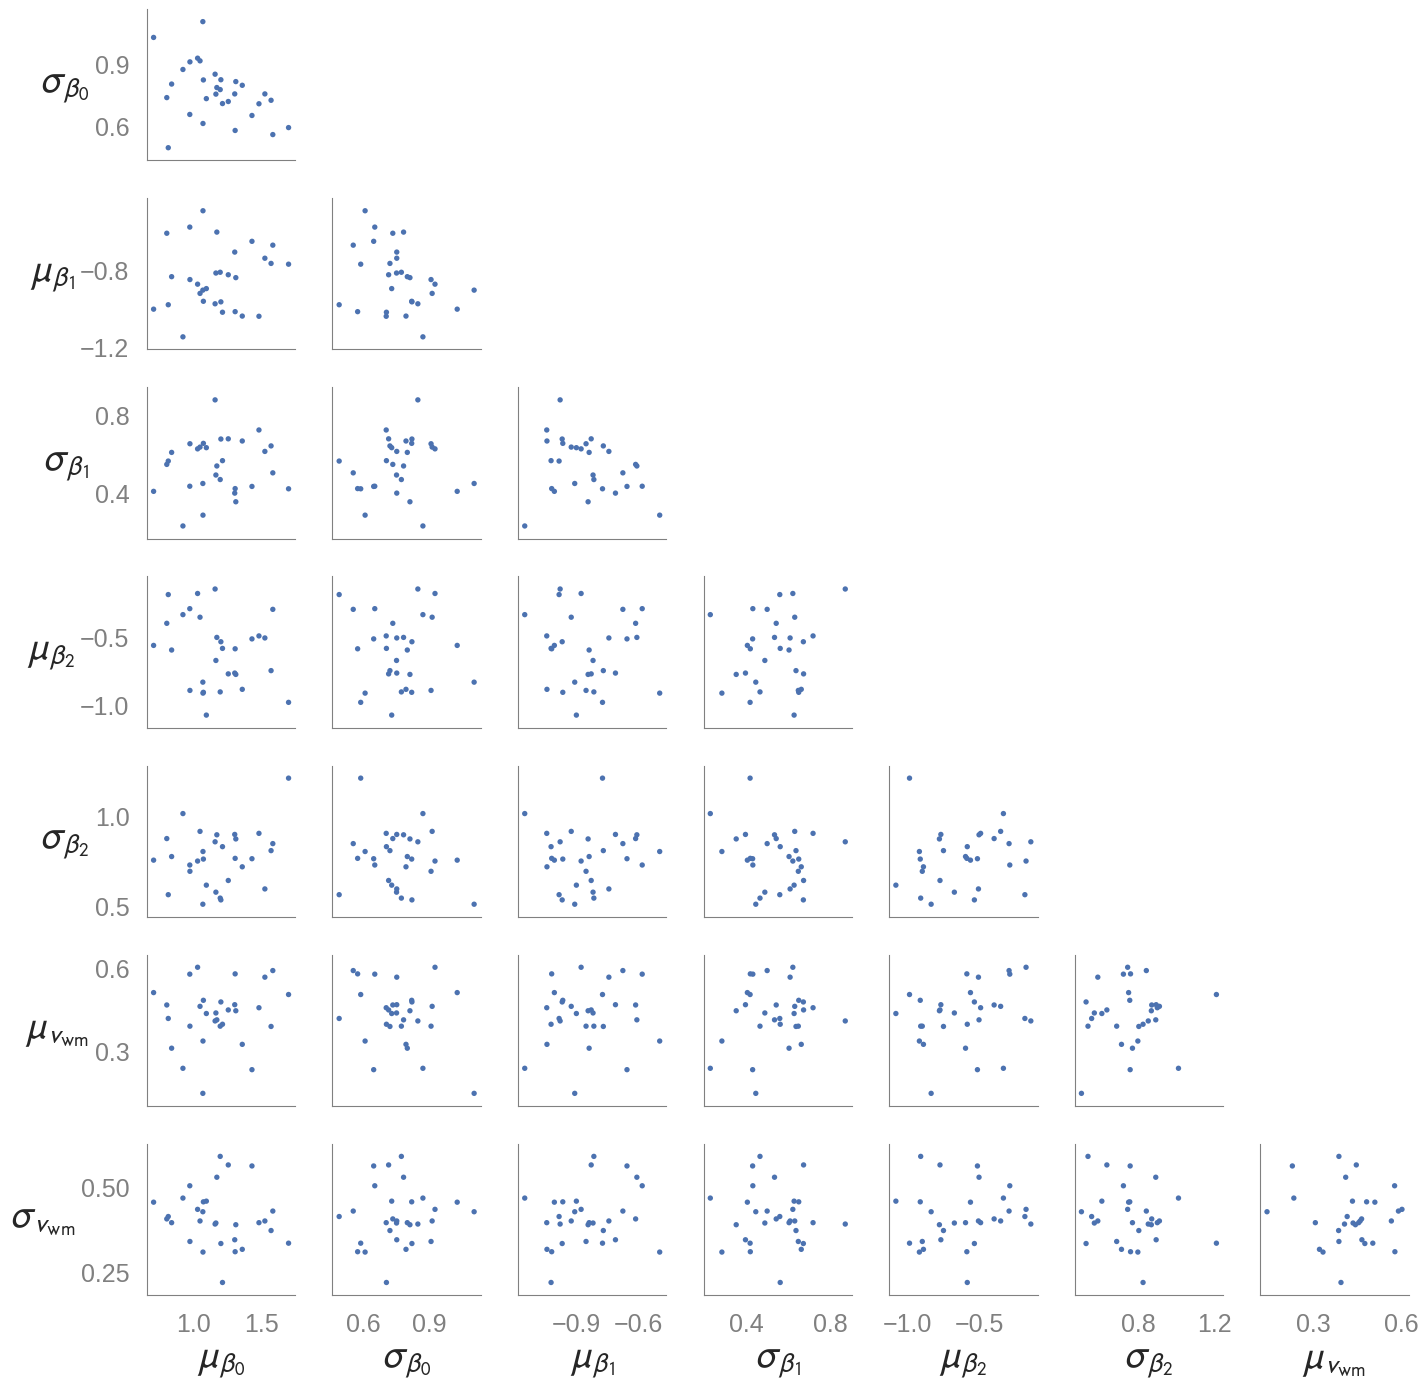

In [20]:
# --- Define your group-level columns and pretty names ---
cols = [
    'recovered_group_log_beta0_mu_mean',
    "recovered_group_log_beta0_sigma_mean",
    'recovered_group_log_beta1_mu_mean',
    "recovered_group_log_beta1_sigma_mean",
    'recovered_group_log_beta2_mu_mean',
    "recovered_group_log_beta2_sigma_mean",
    'recovered_group_log_drift_mu_mean',
    "recovered_group_log_drift_sigma_mean",
]

var_names = [
    r"$\mu_{\beta_{0}}$",
    r"$\sigma_{\beta_{0}}$",
    r"$\mu_{\beta_{1}}$",
    r"$\sigma_{\beta_{1}}$",
    r"$\mu_{\beta_{2}}$",
    r"$\sigma_{\beta_{2}}$",
    r"$\mu_{v_{\text{wm}}}$",
    r"$\sigma_{v_{\text{wm}}}$",
]

# --- Prepare data ---
existing = [c for c in cols if c in df_group_recovered_params.columns]
label_map = {c: v for c, v in zip(cols, var_names) if c in existing}
df_plot = (
    df_group_recovered_params
    .loc[:, existing]
    .select_dtypes(include="number")
    .rename(columns=label_map)
)

# --- Configure global aesthetics ---
sns.set(style="white", context="talk", font_scale=1.0)

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11

# --- Pairplot WITHOUT diagonal distributions ---
g = sns.pairplot(
    df_plot,
    corner=True,
    diag_kind=None,  # <- no hist/kde on diagonal
    height=2,
    plot_kws={"alpha": 1, "s": 15, "edgecolor": "none"},
)

# --- Remove diagonal axes entirely (so no empty diagonal panels) ---
for i in range(len(df_plot.columns)):
    ax = g.axes[i, i]
    if ax is not None:
        ax.set_visible(False)

LABEL_FS = 28
TICK_FS = 18
# --- Style the remaining axes ---
for ax in g.axes.flatten():
    if ax is None or (hasattr(ax, "get_visible") and not ax.get_visible()):
        continue

    ax.set_xlabel(ax.get_xlabel(), fontsize=LABEL_FS)
    ax.set_ylabel(ax.get_ylabel(), fontsize=LABEL_FS, rotation=0, ha="right", va="center")

    ax.set_xmargin(0.05)
    ax.set_ymargin(0.1)

    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=2, integer=True))
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=2, integer=True))

    ax.tick_params(axis="both", colors="gray", width=0.8, labelsize=TICK_FS)
    for spine in ax.spines.values():
        spine.set_color("gray")
        spine.set_linewidth(0.8)

# --- Adjust spacing ---
g.fig.subplots_adjust(wspace=0.25, hspace=0.25)

# --- Save or show ---
plt.rcParams["svg.fonttype"] = "path"
g.savefig("../figures/wald_group_recovered_pairplot.svg",
          bbox_inches="tight", transparent=True)
plt.show()

#### Correlations between individual-level recovered parameters

/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


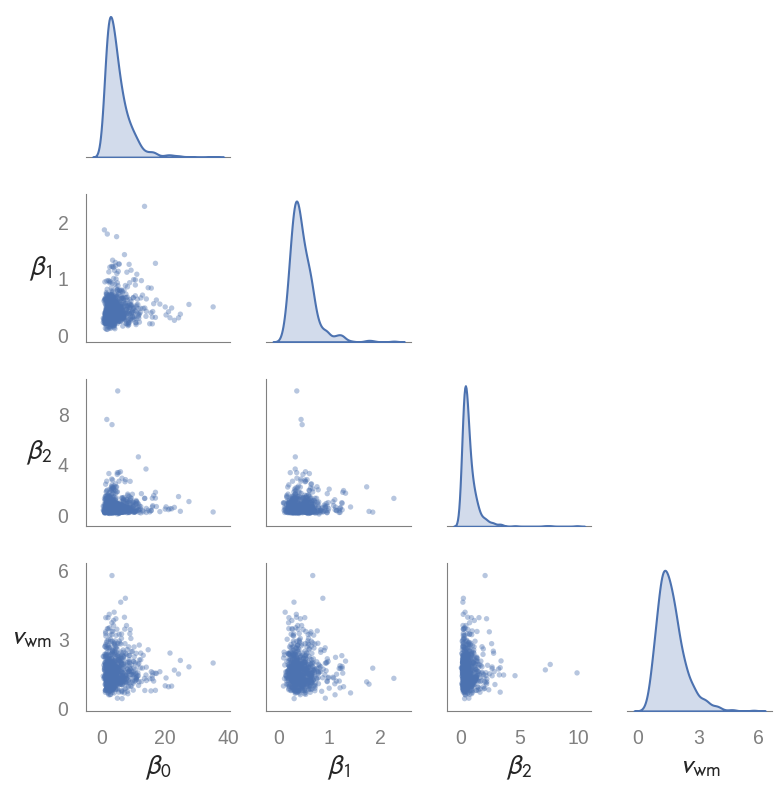

In [214]:
# --- Define your columns and pretty names ---
cols = [
    'recovered_indi_beta0_mean',
    'recovered_indi_beta1_mean',
    'recovered_indi_beta2_mean',
    "recovered_indi_drift_mean",
]

var_names = [
    r"$\beta_{0}$",
    r"$\beta_{1}$",
    r"$\beta_{2}$",
    r"$v_{\text{wm}}$",
]

# --- Prepare data ---
existing = [c for c in cols if c in df_indi_wm_recovered_params.columns]
label_map = {c: v for c, v in zip(cols, var_names) if c in existing}
df_plot = (
    df_indi_wm_recovered_params
    .loc[:, existing]
    .select_dtypes(include="number")
    .rename(columns=label_map)
)

# --- Configure global aesthetics ---
sns.set(style="white", context="talk", font_scale=1.0)

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
     
})


plt.rcParams["axes.labelsize"] = 13
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11

# --- Make the pairplot ---
g = sns.pairplot(
    df_plot,
    diag_kind="kde",          # options: 'hist' or 'kde'
    corner=True,              # only lower triangle
    height=2,                 # subplot size
    plot_kws={"alpha": 0.4, "s": 15, "edgecolor": "none"},
)

# --- Customize each subplot ---


for ax in g.axes.flatten():
    if ax is not None:
        # Labels
        ax.set_xlabel(ax.get_xlabel(), fontsize=20)
        ax.set_ylabel(ax.get_ylabel(), fontsize=20, rotation=0, ha='right', va='center')

        # Make axes tighter (remove whitespace)
        ax.set_xmargin(0.05)
        ax.set_ymargin(0.1)

        # Limit tick count and make them integers
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=3, integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=3, integer=True))

        # Make everything grey and thinner
        ax.tick_params(axis="both", colors="gray", width=0.8, labelsize=14)
        for spine in ax.spines.values():
            spine.set_color("gray")
            spine.set_linewidth(0.8)


# --- Adjust subplot spacing ---
g.fig.subplots_adjust(wspace=0.25, hspace=0.25)

# --- Save or show ---
plt.rcParams['svg.fonttype'] = 'path'  # keep text editable
g.savefig("../figures/wald_indi_recovered_pairplot.svg", bbox_inches="tight", transparent=True)
plt.show()


# DDM parameter recovery analysis

# Paper figures plots

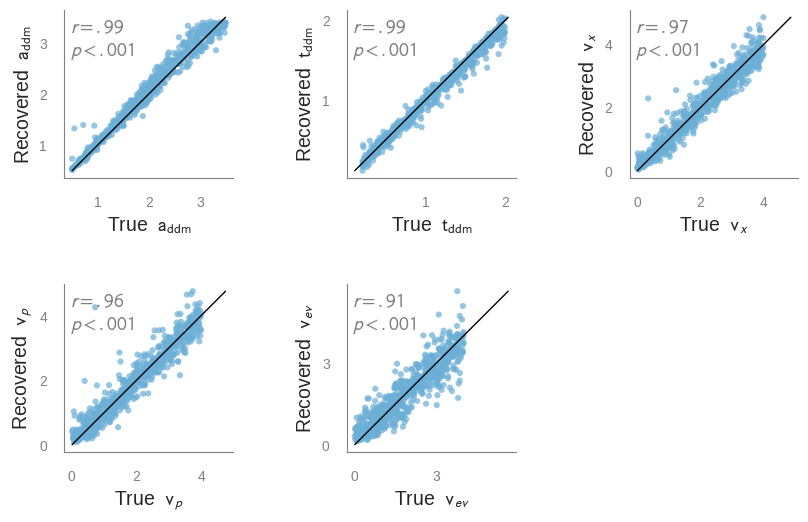

In [47]:

sns.set_style("white")

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

parameters_names_ddm = ['a', 't', 'v_diff_x', 'v_diff_p', 'v_diff_ev']

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for i, param in enumerate(parameters_names_ddm):
    ax = axes[i]
    all_x, all_y = [], []

    for g in range(n_group_param_sets):
        df_g_true = df_indi_synthetic_params[df_indi_synthetic_params['group_parameter_set_ID'] == g]
        df_g_rec  = df_indi_ddm_recovered_params[df_indi_ddm_recovered_params['group_parameter_set_ID'] == g]

        if df_g_true.empty or df_g_rec.empty:
            continue

        x = df_g_true[f'synthetic_indi_{param}'].values
        y = df_g_rec[f'recovered_{param}_mean'].values

        mask = np.isfinite(x) & np.isfinite(y)
        x, y = x[mask], y[mask]
        if len(x) == 0 or len(y) == 0:
            continue

        all_x.append(x)
        all_y.append(y)
        col =  "#6baed6"
        #f"C{g % 10}"
        ax.scatter(x, y, color=col, edgecolors='none', s=20, alpha=0.7)

    # Add 1:1 line and consistent axis limits
    if all_x and all_y:
        all_x = np.concatenate(all_x)
        all_y = np.concatenate(all_y)
        mn = min(all_x.min(), all_y.min())
        mx = max(all_x.max(), all_y.max())
        pad = 0.05 * (mx - mn if mx > mn else 1.0)
        ax.plot([mn, mx], [mn, mx], '-', color="black", lw=1)
        ax.set_xlim(mn - pad, mx + pad)
        ax.set_ylim(mn - pad, mx + pad)

      
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=3))

    # Parameter label formatting
    if param == 'a':
        param_label = r"$\mathrm{a}_{\mathrm{ddm}}$"
    elif param == 't':
        param_label = r"$\mathrm{t}_{\mathrm{ddm}}$"
    elif param == 'v_diff_x':
        param_label = r"$\mathrm{v}_{x}$"
    elif param == 'v_diff_ev':
        param_label = r"$\mathrm{v}_{ev}$"
    elif param == 'v_diff_p':
        param_label = r"$\mathrm{v}_{p}$"

    ax.set_xlabel("True  " + param_label, fontsize=14)
    ax.set_ylabel("Recovered  " + param_label, fontsize=14)
    ax.set_aspect('equal', adjustable='box')

    # Thinner, grey axes and ticks
    ax.tick_params(axis='both', colors='grey', labelcolor='gray', which='major', labelsize=10)
    for spine in ax.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(0.8)

    r_val, p_val = pearsonr(all_x, all_y)
    p_bonferroni_corr = p_val * len(parameters_names_ddm) # Bonferroni correction for multiple testing
    p_text = r"$p < .001$" if p_bonferroni_corr < 0.001 else f"$p = {fmt_no_leading_zero(p_bonferroni_corr, 3)}$" 
    ax.text(0.03, 0.95, f"$r = {fmt_no_leading_zero(r_val, 2)}$\n{p_text}",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=14, color="gray")

    sns.despine(ax=ax, top=True, right=True)

# Remove unused subplots
if len(parameters_names_ddm) < len(axes):
    for j in range(len(parameters_names_ddm), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
plt.rcParams['svg.fonttype'] = 'path' 
plt.savefig("../figures/ddm_parameter_recovery.svg", format="svg", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


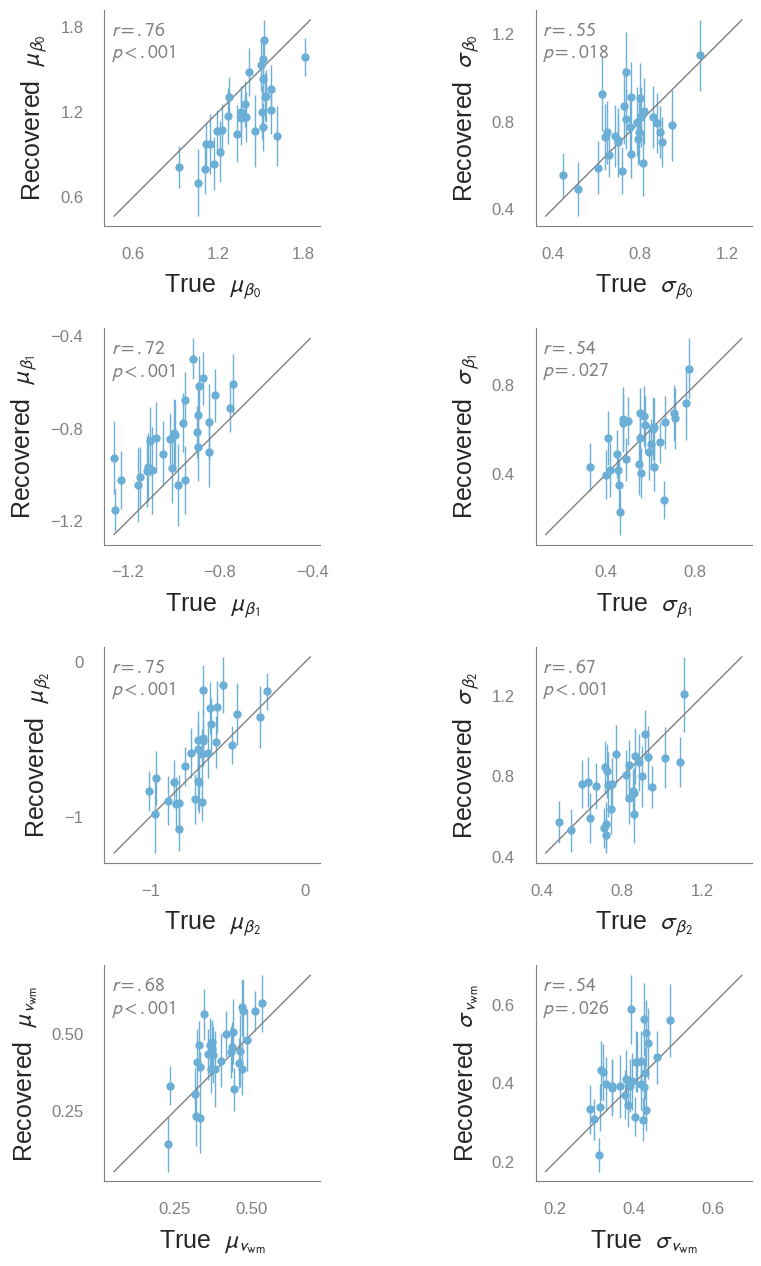

In [34]:

sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

# Parameters and pretty labels
params = ["beta0", "beta1", "beta2", "drift"]
label_mu = {
    "beta0":  r"$\mu_{\beta_{0}}$",
    "beta1":  r"$\mu_{\beta_{1}}$",
    "beta2":  r"$\mu_{\beta_{2}}$",
    "drift":  r"$\mu_{v_{\text{wm}}}$",
}
label_sigma = {
    "beta0":  r"$\sigma_{\beta_{0}}$",
    "beta1":  r"$\sigma_{\beta_{1}}$",
    "beta2":  r"$\sigma_{\beta_{2}}$",
    "drift":  r"$\sigma_{v_{\text{wm}}}$",
}

# 4 rows (params) × 2 cols (μ on left, σ on right)
fig, axes = plt.subplots(4, 2, figsize=(9.5, 13))
color_pt = "#6baed6"

for r, param in enumerate(params):
    # -------- Left column: μ --------
    ax = axes[r, 0]
    xs, ys, yerrs = [], [], []

    for g in range(n_group_param_sets):
        df_g_true = df_group_synthetic_params[df_group_synthetic_params['group_parameter_set_ID'] == g]
        df_g_rec  = df_group_recovered_params[df_group_recovered_params['group_parameter_set_ID'] == g]
        if df_g_true.empty or df_g_rec.empty:
            continue

        x = df_g_true[f'group_log_{param}_mu'].to_numpy()
        y = df_g_rec[f'recovered_group_log_{param}_mu_mean'].to_numpy()
        y_err = df_g_rec[f'recovered_group_log_{param}_mu_sd'].to_numpy()

        mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err)
        x, y, y_err = x[mask], y[mask], y_err[mask]
        if x.size == 0: continue

        xs.append(x); ys.append(y); yerrs.append(y_err)
        ax.errorbar(x, y, yerr=y_err,
                    fmt='o', ls='none',
                    markerfacecolor=color_pt, markeredgecolor=color_pt, markersize=5,
                    ecolor=color_pt, elinewidth=1.0, capsize=0, zorder=2)

    x_all = np.concatenate(xs); y_all = np.concatenate(ys); yerr_all = np.concatenate(yerrs)
    vmin = np.nanmin([x_all.min(), (y_all - yerr_all).min()])
    vmax = np.nanmax([x_all.max(), (y_all + yerr_all).max()])
    pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0)

    ax.plot([vmin, vmax], [vmin, vmax], color="grey", lw=1)
    ax.set_xlim(vmin - pad, vmax + pad)
    ax.set_ylim(vmin - pad, vmax + pad)
    ax.set_aspect('equal', adjustable='box')

    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=3))
    ax.tick_params(axis='both', which='major', colors='gray', labelcolor='gray', labelsize=12, pad=6)

    ax.set_xlabel(rf"True  {label_mu[param]}", fontsize=18, labelpad=8)
    ax.set_ylabel(rf"Recovered  {label_mu[param]}", fontsize=18, labelpad=8)

    for spine in ax.spines.values():
        spine.set_color('gray'); spine.set_linewidth(0.8)
    sns.despine(ax=ax, top=True, right=True)

    r_val, p_val = pearsonr(x_all, y_all)
    p_text = r"$p < .001$" if p_val < 0.001 else f"$p = {fmt_no_leading_zero(p_val, 3)}$" #f"$p = {p_val:.3f}$".lstrip("0") {fmt_no_leading_zero(p_val, 3)}
    ax.text(0.03, 0.95, f"$r = {fmt_no_leading_zero(r_val, 2)}$\n{p_text}",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=14, color="gray")

    # -------- Right column: σ --------
    ax = axes[r, 1]
    xs, ys, yerrs = [], [], []

    for g in range(n_group_param_sets):
        df_g_true = df_group_synthetic_params[df_group_synthetic_params['group_parameter_set_ID'] == g]
        df_g_rec  = df_group_recovered_params[df_group_recovered_params['group_parameter_set_ID'] == g]
        if df_g_true.empty or df_g_rec.empty:
            continue

        x = df_g_true[f'group_log_{param}_sigma'].to_numpy()
        y = df_g_rec[f'recovered_group_log_{param}_sigma_mean'].to_numpy()
        y_err = df_g_rec[f'recovered_group_log_{param}_sigma_sd'].to_numpy()

        mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err)
        x, y, y_err = x[mask], y[mask], y_err[mask]
        if x.size == 0: continue

        xs.append(x); ys.append(y); yerrs.append(y_err)
        ax.errorbar(x, y, yerr=y_err,
                    fmt='o', ls='none',
                    markerfacecolor=color_pt, markeredgecolor=color_pt, markersize=5,
                    ecolor=color_pt, elinewidth=1.0, capsize=0, zorder=2)

    x_all = np.concatenate(xs); y_all = np.concatenate(ys); yerr_all = np.concatenate(yerrs)
    vmin = np.nanmin([x_all.min(), (y_all - yerr_all).min()])
    vmax = np.nanmax([x_all.max(), (y_all + yerr_all).max()])
    pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0)

    ax.plot([vmin, vmax], [vmin, vmax], color="grey", lw=1)
    ax.set_xlim(vmin - pad, vmax + pad)
    ax.set_ylim(vmin - pad, vmax + pad)
    ax.set_aspect('equal', adjustable='box')

    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=3))
    ax.tick_params(axis='both', which='major', colors='gray', labelcolor='gray', labelsize=12, pad=6)

    ax.set_xlabel(rf"True  {label_sigma[param]}", fontsize=18, labelpad=8)
    ax.set_ylabel(rf"Recovered  {label_sigma[param]}", fontsize=18, labelpad=8)

    for spine in ax.spines.values():
        spine.set_color('gray'); spine.set_linewidth(0.8)
    sns.despine(ax=ax, top=True, right=True)

    r_val, p_val = pearsonr(x_all, y_all)
    p_bonferroni_corr = p_val * n_params_wm 
    p_text = r"$p < .001$" if p_bonferroni_corr < 0.001 else f"$p = {fmt_no_leading_zero(p_bonferroni_corr, 3)}$" #f"$p = {p_val:.3f}$".lstrip("0") {fmt_no_leading_zero(p_val, 3)}
    ax.text(0.03, 0.95, f"$r = {fmt_no_leading_zero(r_val, 2)}$\n{p_text}",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=14, color="gray")

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'path' 
plt.savefig("../figures/group_parameter_recovery_wald.svg",
             format="svg", bbox_inches="tight", transparent=True)
plt.show()


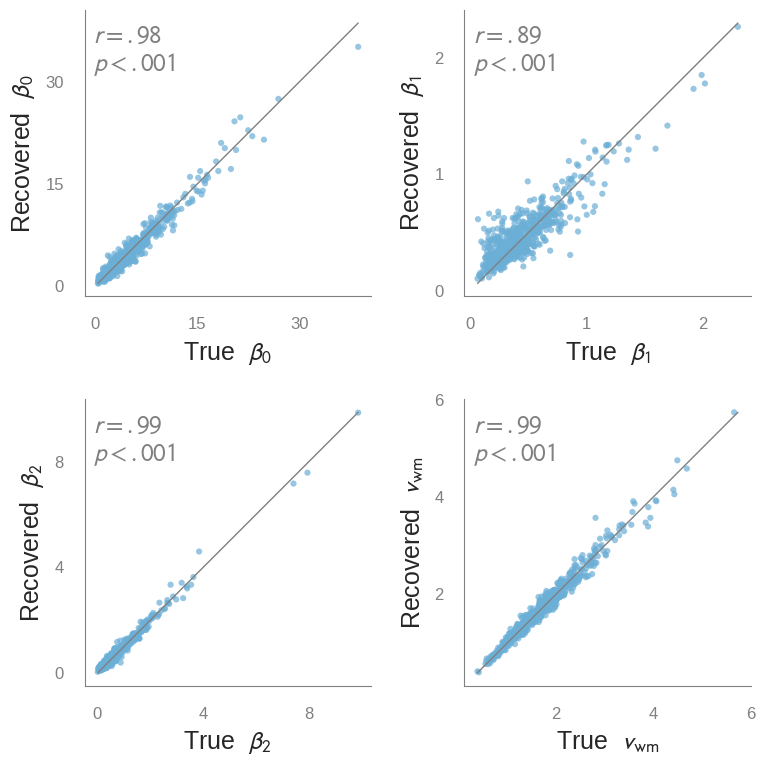

In [35]:


sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

# Parameters and pretty labels
params = ["beta0", "beta1", "beta2", "drift"]
label_map = {
    "beta0":  r"$\beta_{0}$",
    "beta1":  r"$\beta_{1}$",
    "beta2":  r"$\beta_{2}$",
    "drift":  r"$v_{\text{wm}}$",
}

# Create 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
color_pt = "#6baed6"

# Loop through parameters
for i, param in enumerate(params):
    ax = axes[i]
    xs, ys = [], []

    for g in range(n_group_param_sets):
        df_true = df_indi_synthetic_params[df_indi_synthetic_params['group_parameter_set_ID'] == g]
        df_rec  = df_indi_wm_recovered_params[df_indi_wm_recovered_params['group_parameter_set_ID'] == g]

        if df_true.empty or df_rec.empty:
            continue

        x = df_true[f'synthetic_indi_{param}'].to_numpy()
        y = df_rec[f'recovered_indi_{param}_mean'].to_numpy()

        mask = np.isfinite(x) & np.isfinite(y)
        x, y = x[mask], y[mask]
        if len(x) == 0:
            continue

        xs.append(x)
        ys.append(y)

        ax.scatter(
            x, y,
            s=20,
            color=color_pt,
            alpha=0.7,
            edgecolors='none'
        )

    # Compute global limits
    x_all = np.concatenate(xs)
    y_all = np.concatenate(ys)
    vmin = np.nanmin([x_all.min(), y_all.min()])
    vmax = np.nanmax([x_all.max(), y_all.max()])
    pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0)

    # Diagonal line
    ax.plot([vmin, vmax], [vmin, vmax], color="grey", lw=1)

    # Axis limits & aspect
    ax.set_xlim(vmin - pad, vmax + pad)
    ax.set_ylim(vmin - pad, vmax + pad)
    ax.set_aspect('equal', adjustable='box')

    # Tick formatting
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=3))
    ax.tick_params(axis='both', which='major', colors='gray', labelcolor='gray', labelsize=12, pad=6)

    # Labels
    nice = label_map[param]
    ax.set_xlabel(rf"True  {nice}", fontsize=18, labelpad=6)
    ax.set_ylabel(rf"Recovered  {nice}", fontsize=18, labelpad=6)

    # Grey spines
    for spine in ax.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(0.8)
    sns.despine(ax=ax, top=True, right=True)

    # Correlation
    r, p = pearsonr(x_all, y_all)
    p_bonferroni_corr = p * n_params_wm 
    p_text = r"$p < .001$" if p_bonferroni_corr < 0.001 else f"$p = {fmt_no_leading_zero(p_bonferroni_corr, 3)}$" 

    ax.text(0.03, 0.95, f"$r = {fmt_no_leading_zero(r, 2)}$\n{p_text}",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=18, color="gray")

# Clean up empty subplots (if any)
if len(params) < len(axes):
    for j in range(len(params), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'path' 
plt.savefig("../figures/individual_parameter_recovery_wald.svg", format="svg", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
